# Brain Tumor Classification from MRI

Importing the necessary libraries and modules.

In [1]:
import numpy as np # l|inear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Imports 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import random
import tensorflow as tf
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# base_path and labels.
base_path = '../input/brain-tumor-classification-mri/'
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [4]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 32
VERBOSE = 1

Reading the dataset.

In [5]:
# Dataset from the training folder.
x_train=[]
y_train=[]
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Dataset from the testing folder..

for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'Testing'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

print('Testing dataset Loading complete.')


  6%|▌         | 6/105 [00:00<00:01, 50.89it/s]

Training dataset Loading complete.


100%|██████████| 100/100 [00:01<00:00, 98.38it/s]


Testing dataset Loading complete.


Encoding the y_train and y_test to numbers and one-hot encoding it.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


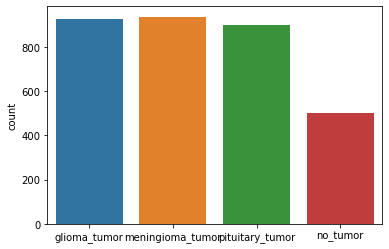

In [6]:
sns.countplot(y_train)
plt.show()

Sample images of each class

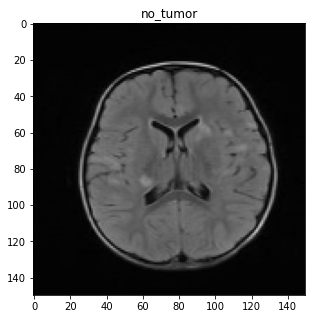

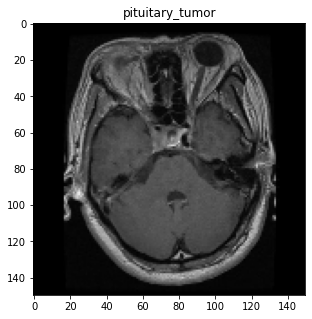

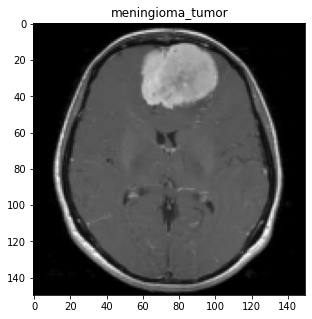

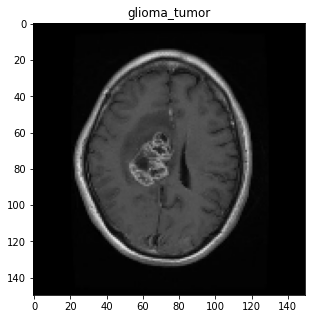

In [7]:
j=0
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True, vertical_flip=False
)

datagen.fit(x_train)
x_train.shape

(3264, 150, 150, 3)

In [9]:
# Splitting of dataset for Testing.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.20, random_state=0) #change

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)


Shapes X : Train : (2611, 150, 150, 3)  Test : (653, 150, 150, 3)
Shapes Y : Train : (2611,)  Test : (653,)


Encoding the y_train and y_test to numbers and one-hot encoding it.

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## 1. MODEL:EfficientNetB0

In [11]:
# Importing the model and initializing.
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
# Adding Top Layers.
model1 = effnet.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(0.5)(model1)
model1 = tf.keras.layers.Dense(4, activation = 'softmax')(model1)
model1 = tf.keras.models.Model(inputs = effnet.input, outputs = model1)

1.1 Model Summary.

In [13]:
# Model summary.
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
# Compiling Model
model1.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [15]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

1.2 Training the model.

In [16]:
# Fitting the model
history1 = model1.fit(x_train, y_train, validation_split=0.1, epochs = 10, verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10
74/74 [==============================] - 25s 159ms/step - loss: 0.6637 - accuracy: 0.7459 - val_loss: 0.5651 - val_accuracy: 0.8435

Epoch 00001: val_accuracy improved from -inf to 0.84351, saving model to effnet.h5
Epoch 2/10
74/74 [==============================] - 9s 116ms/step - loss: 0.2416 - accuracy: 0.9310 - val_loss: 0.3070 - val_accuracy: 0.9008

Epoch 00002: val_accuracy improved from 0.84351 to 0.90076, saving model to effnet.h5
Epoch 3/10
74/74 [==============================] - 9s 117ms/step - loss: 0.1349 - accuracy: 0.9549 - val_loss: 0.3301 - val_accuracy: 0.8931

Epoch 00003: val_accuracy did not improve from 0.90076
Epoch 4/10
74/74 [==============================] - 9s 115ms/step - loss: 0.0914 - accuracy: 0.9679 - val_loss: 0.6482 - val_accuracy: 0.7901

Epoch 00004: val_accuracy did not improve from 0.90076

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
74/74 [==============================] - 8s 115ms/step -

1.3 Training, Loss vs epoch.

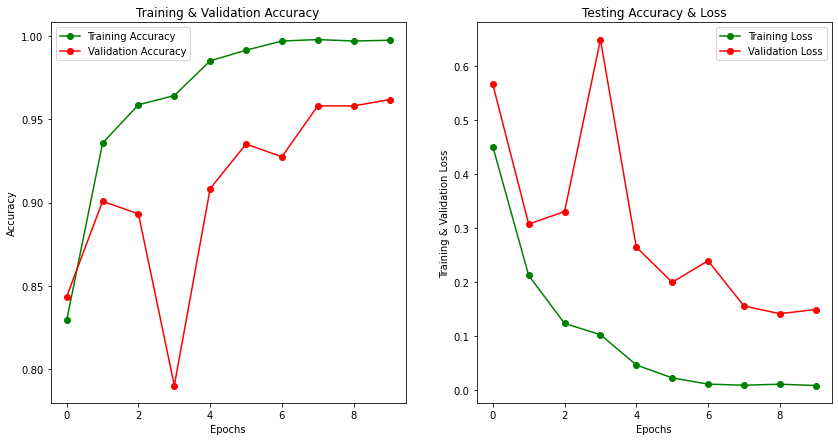

In [18]:
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

1.4 Model Performance

In [19]:
# Evaluating Model.
result1=model1.evaluate(x_test, y_test)
print("Testing Loss :", result1[0])
print("Testing Accuracy :", result1[1]*100, "%")

21/21 [==============================] - 1s 25ms/step - loss: 0.0703 - accuracy: 0.9816
Testing Loss : 0.0702740028500557
Testing Accuracy : 98.16232919692993 %


In [20]:
predictions1 = model1.predict(x_test)
predictions1 = np.argmax(predictions1, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

1.5 Classification Report.

In [21]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions1 )
print(cf_report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       104
           1       0.99      0.99      0.99       196
           2       0.96      0.99      0.97       184
           3       0.98      0.96      0.97       169

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



1.6 Confusion Matrix

<AxesSubplot:>

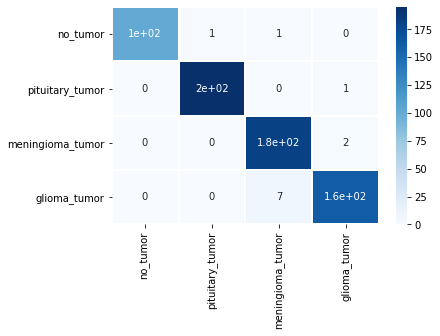

In [22]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions1)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

## 2. MODEL:Xception

In [23]:
# Importing the model and initializing.
from tensorflow.keras.applications import Xception
xception = Xception(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

83689472/83683744 [==============================] - 1s 0us/step


In [24]:
# Adding Top Layers.
model2 = xception.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation = 'softmax')(model2)
model2 = tf.keras.models.Model(inputs = xception.input, outputs = model2)

2.1 Model Summary.

In [25]:
# Summary of the model.
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [26]:
# Compiling the model.
model2.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [27]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

2.2 Training the model.

In [28]:
# Fitting the model
history2 = model2.fit(x_train, y_train, validation_split=0.1,epochs = 12,  verbose = VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/12
74/74 [==============================] - 22s 223ms/step - loss: 0.7563 - accuracy: 0.7124 - val_loss: 2.8787 - val_accuracy: 0.6336

Epoch 00001: val_accuracy improved from -inf to 0.63359, saving model to xception.h5
Epoch 2/12
74/74 [==============================] - 14s 189ms/step - loss: 0.2493 - accuracy: 0.9158 - val_loss: 1.5606 - val_accuracy: 0.7786

Epoch 00002: val_accuracy improved from 0.63359 to 0.77863, saving model to xception.h5
Epoch 3/12
74/74 [==============================] - 14s 189ms/step - loss: 0.1662 - accuracy: 0.9462 - val_loss: 1.3032 - val_accuracy: 0.7252

Epoch 00003: val_accuracy did not improve from 0.77863
Epoch 4/12
74/74 [==============================] - 14s 188ms/step - loss: 0.1339 - accuracy: 0.9578 - val_loss: 1.0098 - val_accuracy: 0.7977

Epoch 00004: val_accuracy improved from 0.77863 to 0.79771, saving model to xception.h5
Epoch 5/12
74/74 [==============================] - 14s 189ms/step - loss: 0.1029 - accuracy: 0.9719 - val_l

2.3 Training, Loss vs epoch.

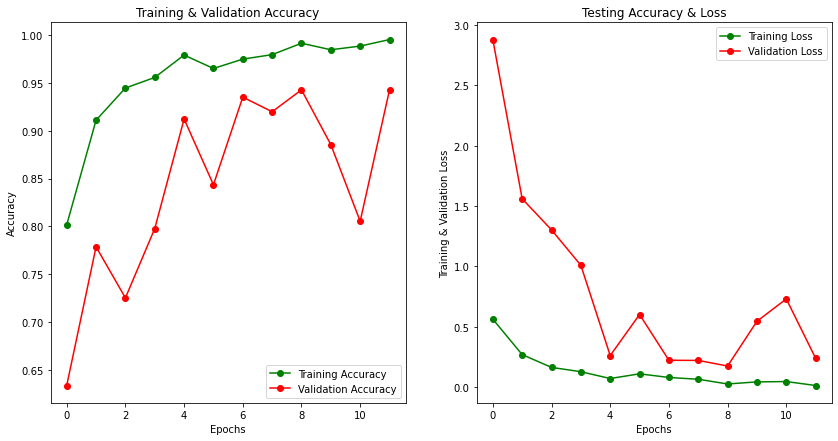

In [29]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

2.4 Model Performance

In [30]:
# Evaluating Model.
result2=model2.evaluate(x_test, y_test)
print("Testing Loss :", result2[0])
print("Testing Accuracy :", result2[1]*100, "%")

21/21 [==============================] - 1s 39ms/step - loss: 0.2457 - accuracy: 0.9525
Testing Loss : 0.2457462102174759
Testing Accuracy : 95.25268077850342 %


In [31]:
predictions2 = model2.predict(x_test)
predictions2 = np.argmax(predictions2, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

2.5 Classification Report.

In [32]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions2 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       104
           1       1.00      0.96      0.98       196
           2       0.91      0.99      0.95       184
           3       0.93      0.90      0.92       169

    accuracy                           0.95       653
   macro avg       0.96      0.95      0.95       653
weighted avg       0.95      0.95      0.95       653



2.6 Confusion Matrix

<AxesSubplot:>

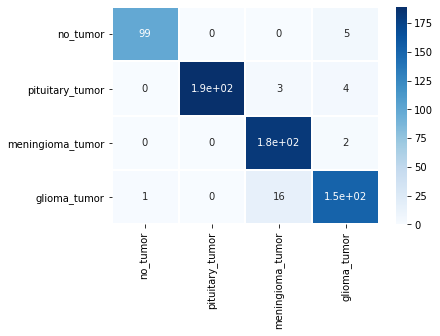

In [33]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions2)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

## 3. MODEL:MobileNet

In [34]:
# Importing the model and initializing.
from tensorflow.keras.applications.mobilenet import MobileNet
mblnt = MobileNet(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

17227776/17225924 [==============================] - 0s 0us/step


In [35]:
# Adding Top Layers.
model3 = mblnt.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(0.5)(model3)
model3 = tf.keras.layers.Dense(4, activation = 'softmax')(model3)
model3 = tf.keras.models.Model(inputs = mblnt.input, outputs = model3)

3.1 Model Summary.

In [36]:
# Summary of the model.
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 75, 75, 32)        0   

In [37]:
# Compiling Model
model3.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [38]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("mblnt.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

3.2 Training the model.

In [39]:
# Fitting the model
history3 = model3.fit(x_train, y_train, validation_split=0.1, epochs = 12, verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/12
74/74 [==============================] - 10s 95ms/step - loss: 1.0161 - accuracy: 0.7062 - val_loss: 2.3651 - val_accuracy: 0.6298

Epoch 00001: val_accuracy improved from -inf to 0.62977, saving model to mblnt.h5
Epoch 2/12
74/74 [==============================] - 5s 71ms/step - loss: 0.3420 - accuracy: 0.8960 - val_loss: 0.8569 - val_accuracy: 0.7481

Epoch 00002: val_accuracy improved from 0.62977 to 0.74809, saving model to mblnt.h5
Epoch 3/12
74/74 [==============================] - 5s 72ms/step - loss: 0.2023 - accuracy: 0.9307 - val_loss: 0.8470 - val_accuracy: 0.8588

Epoch 00003: val_accuracy improved from 0.74809 to 0.85878, saving model to mblnt.h5
Epoch 4/12
74/74 [==============================] - 5s 72ms/step - loss: 0.1538 - accuracy: 0.9474 - val_loss: 0.6775 - val_accuracy: 0.8244

Epoch 00004: val_accuracy did not improve from 0.85878
Epoch 5/12
74/74 [==============================] - 5s 71ms/step - loss: 0.1439 - accuracy: 0.9554 - val_loss: 0.3286 - val_

3.3 Training, Loss vs epoch.

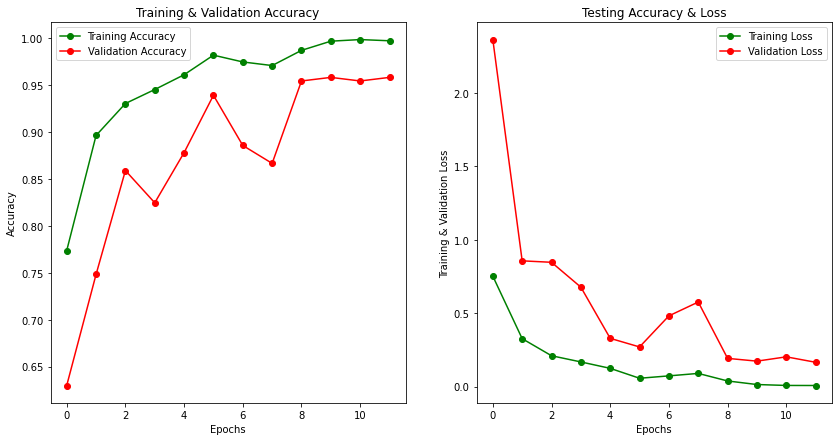

In [40]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']
val_acc = history3.history['val_accuracy']
val_loss = history3.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

3.4 Model Performance

In [41]:
# Evaluating Model.
result3=model3.evaluate(x_test, y_test)
print("Testing Loss :", result3[0])
print("Testing Accuracy :", result3[1]*100, "%")

21/21 [==============================] - 0s 12ms/step - loss: 0.1439 - accuracy: 0.9602
Testing Loss : 0.1439182460308075
Testing Accuracy : 96.01837396621704 %


In [42]:
predictions3 = model3.predict(x_test)
predictions3 = np.argmax(predictions3, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

3.5 Classification Report.

In [43]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions3 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       104
           1       0.97      0.99      0.98       196
           2       0.95      0.96      0.95       184
           3       0.95      0.93      0.94       169

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



3.6 Confusion Matrix

<AxesSubplot:>

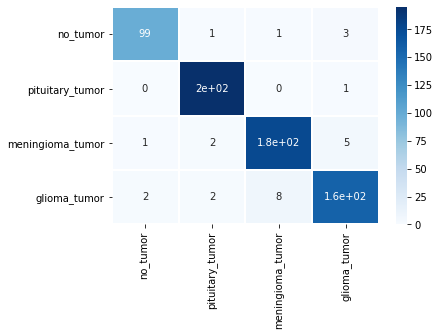

In [44]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions3)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

## 4. MODEL:ResNet50

In [45]:
# Importing the model and initializing.
from tensorflow.keras.applications.resnet import ResNet50
rsnet = ResNet50(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [46]:
# Adding Top Layers.
model4 = rsnet.output
model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
model4 = tf.keras.layers.Dropout(0.5)(model4)
model4 = tf.keras.layers.Dense(4, activation = 'softmax')(model4)
model4 = tf.keras.models.Model(inputs = rsnet.input, outputs = model4)

4.1 Model Summary.

In [47]:
# Summary of the model.
model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [48]:
# Compiling Model
model4.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [49]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("rsnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

4.2 Training the model.

In [50]:
# Fitting the model
history4 = model4.fit(x_train, y_train,  validation_split=0.1,epochs = 12,  verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/12
74/74 [==============================] - 17s 136ms/step - loss: 0.9788 - accuracy: 0.6626 - val_loss: 1722.8483 - val_accuracy: 0.2290

Epoch 00001: val_accuracy improved from -inf to 0.22901, saving model to rsnet.h5
Epoch 2/12
74/74 [==============================] - 8s 102ms/step - loss: 0.5041 - accuracy: 0.8298 - val_loss: 702.6061 - val_accuracy: 0.3092

Epoch 00002: val_accuracy improved from 0.22901 to 0.30916, saving model to rsnet.h5
Epoch 3/12
74/74 [==============================] - 8s 102ms/step - loss: 0.2886 - accuracy: 0.9016 - val_loss: 0.6416 - val_accuracy: 0.8282

Epoch 00003: val_accuracy improved from 0.30916 to 0.82824, saving model to rsnet.h5
Epoch 4/12
74/74 [==============================] - 8s 103ms/step - loss: 0.1613 - accuracy: 0.9521 - val_loss: 0.3463 - val_accuracy: 0.8855

Epoch 00004: val_accuracy improved from 0.82824 to 0.88550, saving model to rsnet.h5
Epoch 5/12
74/74 [==============================] - 8s 102ms/step - loss: 0.1105 - ac

4.3 Training, Loss vs epoch.

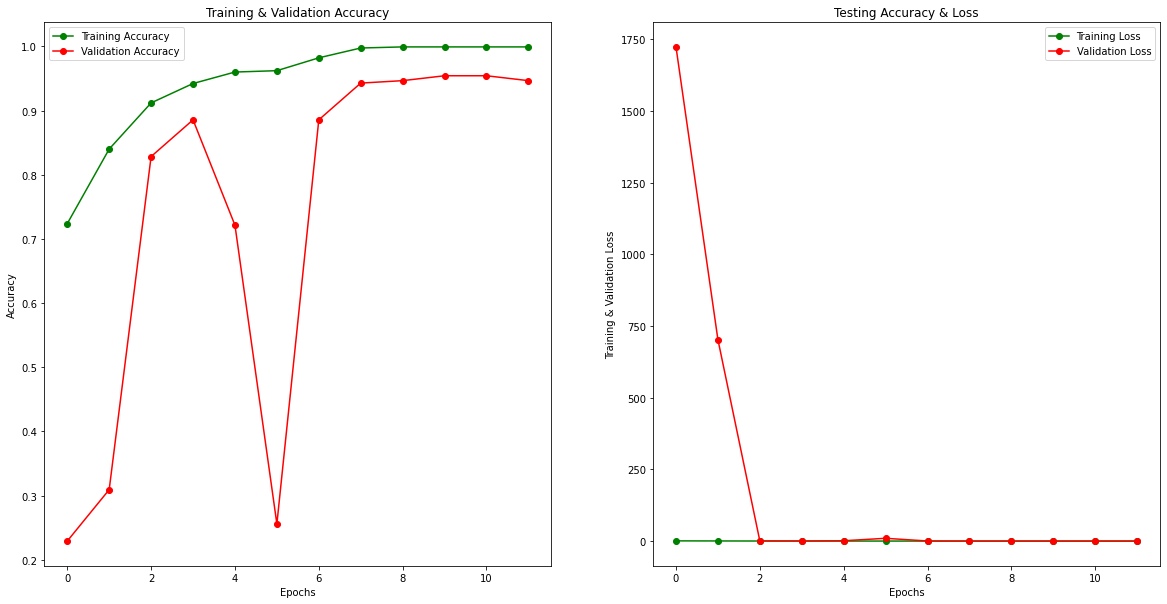

In [51]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history4.history['accuracy']
train_loss = history4.history['loss']
val_acc = history4.history['val_accuracy']
val_loss = history4.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

4.4 Model Performance

In [52]:
# Evaluating Model.
result4=model4.evaluate(x_test, y_test)
print("Testing Loss :", result4[0])
print("Testing Accuracy :", result4[1]*100, "%")

21/21 [==============================] - 1s 32ms/step - loss: 0.1210 - accuracy: 0.9632
Testing Loss : 0.12100030481815338
Testing Accuracy : 96.32465839385986 %


In [53]:
predictions4 = model4.predict(x_test)
predictions4 = np.argmax(predictions4, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

4.5 Classification Report.

In [54]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions4 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       104
           1       0.99      0.98      0.99       196
           2       0.93      0.98      0.95       184
           3       0.96      0.92      0.94       169

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



4.6 Confusion Matrix

<AxesSubplot:>

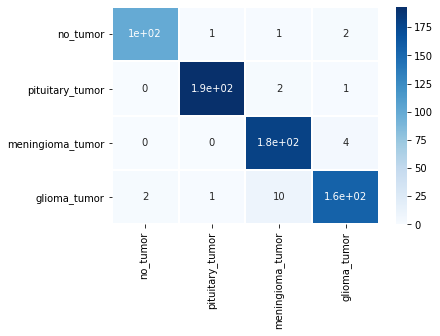

In [55]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions4)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)